# Catalyst 01 - Analyzing Earning Announcement Data

### 1.2 Data Processing and Cleaning

In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd

def fetch_earnings_data(ticker):
    # Set up Selenium to run headlessly
    options = Options()
    options.headless = True
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--window-size=1920x1080")

    driver = webdriver.Chrome(options=options)
    url = f"https://finance.yahoo.com/calendar/earnings?symbol={ticker}"
    driver.get(url)

    # Find the rows of the earnings table
    rows = driver.find_elements(By.CSS_SELECTOR, 'table tbody tr')

    data = []

    for row in rows:
        cols = row.find_elements(By.TAG_NAME, 'td')
        cols = [elem.text for elem in cols]
        data.append(cols)

    # Close the WebDriver
    driver.quit()

    # Assuming the data structure is as expected, create a DataFrame
    columns = ['Symbol', 'Company', 'Earnings Date', 'EPS Estimate', 'Reported EPS', 'Surprise(%)']
    df = pd.DataFrame(data, columns=columns)

    return df

# Example usage:
ticker = "SAP"
earnings_data = fetch_earnings_data(ticker)

# Extract the time and timezone information into a new column
earnings_data['Earnings Time'] = earnings_data['Earnings Date'].str.extract(r'(\d{1,2} [AP]MEDT)')

# Extract just the date part from the "Earnings Date" column
earnings_data['Earnings Date'] = earnings_data['Earnings Date'].str.extract(r'(\b\w+ \d{1,2}, \d{4})')

# Convert string date to datetime
earnings_data['Earnings Date'] = pd.to_datetime(earnings_data['Earnings Date'], format='%b %d, %Y')

# Convert datetime to desired string format
earnings_data['Earnings Date'] = earnings_data['Earnings Date'].dt.strftime('%Y-%m-%d')

earnings_data['Surprise(%)'] = earnings_data['Surprise(%)'].str.replace('+', '').astype(float)

earnings_data


,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise(%),Earnings Time
0,SAP,SAP SE,2024-01-23,1.58,1.41,-10.48,NaN
1,SAP,SAP SE,2023-10-18,1.36,1.45,6.50,12 PMEDT
2,SAP,SAP SE,2023-07-20,1.16,3.14,169.59,8 AMEDT
3,SAP,SAP SE,2023-04-20,1.1,1.27,15.98,9 PMEDT
4,SAP,SAP SE,2023-01-25,1.37,0.99,-27.80,NaN
...,...,...,...,...,...,...,...
95,SAP,SAP SE,2000-10-19,0.11,0.06,-44.33,12 AMEDT
96,SAP,SAP SE,2000-07-25,0.12,0.11,-6.38,12 AMEDT
97,SAP,SAP SE,2000-04-19,0.09,0.03,-68.23,12 AMEDT
98,SAP,SAP SE,2000-01-25,0.15,0.15,-0.51,NaN


## 2. Stock Prices and EPS


[*********************100%%**********************]  1 of 1 completed


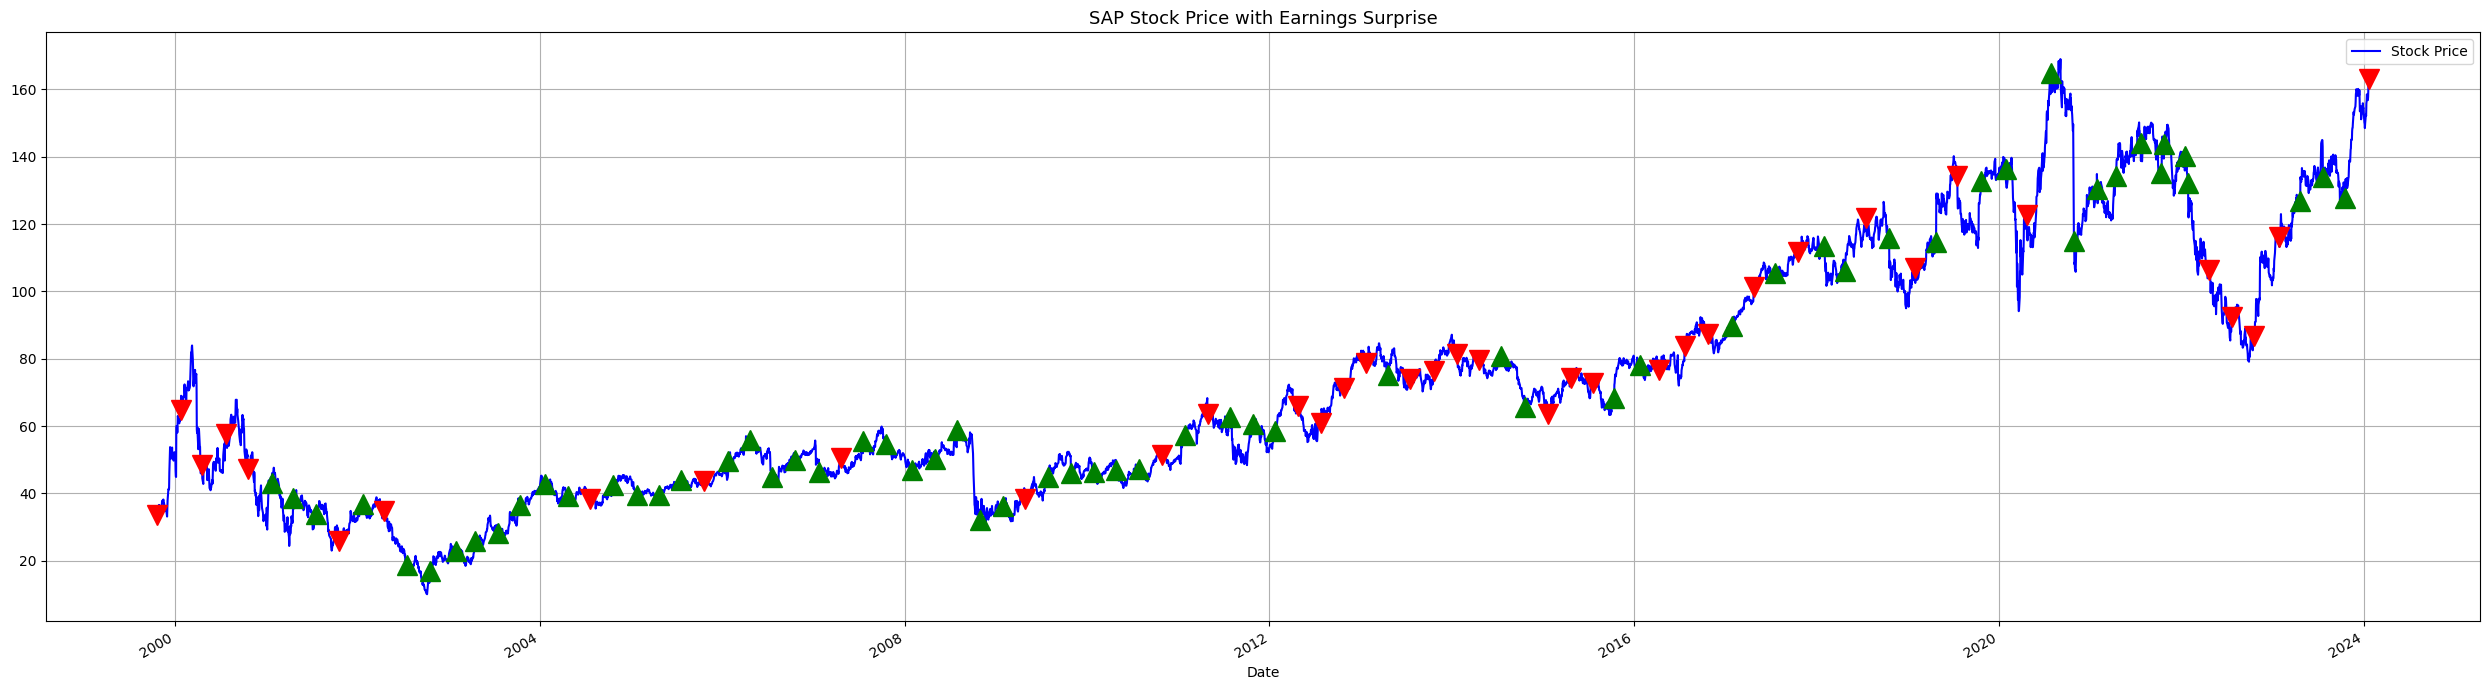

In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from bisect import bisect_left

# Assuming you have earnings_data defined before this code snippet

# Convert 'Earnings Date' to Timestamp
earnings_data['Earnings Date'] = pd.to_datetime(earnings_data['Earnings Date'])

# Fetch stock price data
ticker = 'SAP'
stock_data = yf.download(ticker, start=earnings_data['Earnings Date'].min(), end=earnings_data['Earnings Date'].max())

# Plotting stock data
plt.figure(figsize=(25, 7))
stock_data['Close'].plot(label='Stock Price', color='blue')

# Plotting earnings surprise
for index, row in earnings_data.iterrows():
    date = row['Earnings Date']
    # If exact date is not available, use the closest available date
    if date not in stock_data.index:
        pos = bisect_left(stock_data.index, date)
        date = stock_data.index[min(pos, len(stock_data.index) - 1)]

    if row['Surprise(%)'] > 0:
        color = 'green'
        marker = '^'
    else:
        color = 'red'
        marker = 'v'

    plt.plot(date, stock_data.loc[date, 'Close'], marker, color=color, markersize=15)

plt.title(f'{ticker} Stock Price with Earnings Surprise', fontsize=13)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2.2 The Price Effect of Earnings Announcements
**2.2.1 Calculating Price Effect**

A crucial aspect of earnings analysis is assessing the price effect, which measures the stock's price movement before and after the earnings announcement.

The following code enriches the earnings_data DataFrame with new columns that capture the stock's price before and after the earnings announcement, as well as the percentage change, which is the price effect.

In [11]:
import yfinance as yf
import pandas as pd

# Assuming 'earnings_data' is the DataFrame and has an 'Earnings Date' column in string format
earnings_data['Earnings Date'] = pd.to_datetime(earnings_data['Earnings Date'])

# Now add buffer days to the start and end dates
buffer_days = 10
startDate = earnings_data['Earnings Date'].min() - pd.Timedelta(days=buffer_days)
endDate = earnings_data['Earnings Date'].max() + pd.Timedelta(days=buffer_days)

# Fetch SAP SE stock price data with additional buffer days
stock_data = yf.download(ticker, start=startDate, end=endDate)

# Fetch SAP SE stock price data
stock_data = yf.download(ticker, start=startDate, end=endDate)

# Function to compute price effect
def compute_price_effect(earnings_date, stock_data):
    try:
        # For "Price Before", if missing, we use the most recent previous price
        price_before = stock_data.loc[:pd.Timestamp(earnings_date) - pd.Timedelta(days=1), 'Close'].ffill().iloc[-1]
        
        price_on = stock_data.loc[pd.Timestamp(earnings_date), 'Close']
        
        # For "Price After", if missing, we use the next available price
        price_after = stock_data.loc[pd.Timestamp(earnings_date) + pd.Timedelta(days=1):, 'Close'].bfill().iloc[0]
        
        price_effect = ((price_after - price_before) / price_before) * 100
    except (KeyError, IndexError):  # in case the date is missing in the stock_data even after filling
        return None, None, None, None
    return price_before, price_on, price_after, price_effect

# Apply the function
earnings_data['Price Before'], earnings_data['Price On'], earnings_data['Price After'], earnings_data['Price Effect (%)'] = zip(*earnings_data['Earnings Date'].apply(compute_price_effect, stock_data=stock_data))

#earnings_data['Surprise(%)'] = earnings_data['Surprise(%)'].str.replace('+', '').astype(float)

earnings_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise(%),Earnings Time,Price Before,Price On,Price After,Price Effect (%)
0,SAP,SAP SE,2024-01-23,1.58,1.41,-10.48,NaN,163.210007,163.380005,174.610001,6.984862
1,SAP,SAP SE,2023-10-18,1.36,1.45,6.50,12 PMEDT,130.490005,127.610001,133.380005,2.214729
2,SAP,SAP SE,2023-07-20,1.16,3.14,169.59,8 AMEDT,143.000000,133.929993,134.020004,-6.279717
3,SAP,SAP SE,2023-04-20,1.1,1.27,15.98,9 PMEDT,127.300003,126.860001,133.949997,5.223876
4,SAP,SAP SE,2023-01-25,1.37,0.99,-27.80,NaN,116.190002,116.160004,114.099998,-1.798781
...,...,...,...,...,...,...,...,...,...,...,...
95,SAP,SAP SE,2000-10-19,0.11,0.06,-44.33,12 AMEDT,51.437500,47.312500,46.125000,-10.328068
96,SAP,SAP SE,2000-07-25,0.12,0.11,-6.38,12 AMEDT,57.687500,57.500000,56.562500,-1.950163
97,SAP,SAP SE,2000-04-19,0.09,0.03,-68.23,12 AMEDT,49.812500,48.375000,44.437500,-10.790464
98,SAP,SAP SE,2000-01-25,0.15,0.15,-0.51,NaN,62.500000,64.687500,69.000000,10.400000


### 2.2.2 Stock Price, Effect Percentage, EPS Surprise

To further our analysis, we visualize the relationship between stock prices around the earnings announcement dates, the price effect percentage, and the EPS surprise. 
This is achieved through the following Python code which generates a multi-faceted bar and line plot.

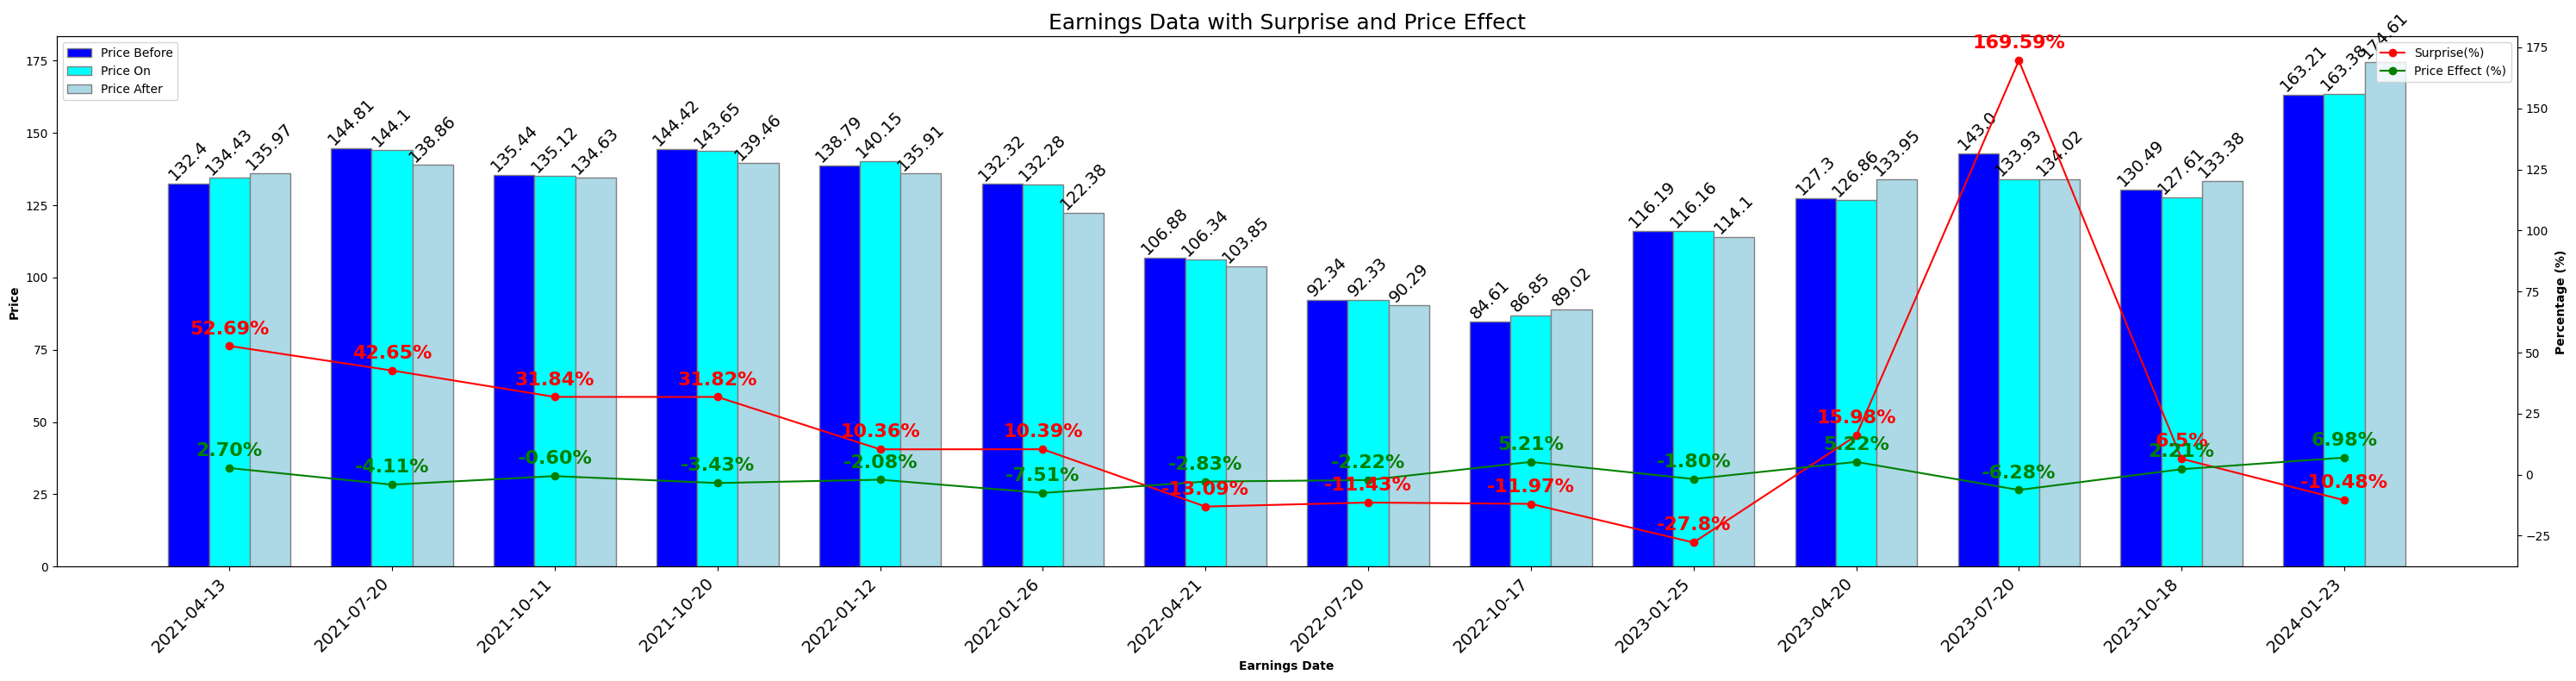

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

#df = pd.DataFrame(data)
#df['Earnings Date'] = pd.to_datetime(df['Earnings Date'])

# Sort the dataframe by 'Earnings Date' in ascending order
latest_earnings_data = earnings_data.sort_values(by='Earnings Date').tail(14)

# Setting up the plot
fig, ax1 = plt.subplots(figsize=(30,8))

# Bar positions
positions = range(len(latest_earnings_data ))
width = 0.25
r1 = [pos - width for pos in positions]
r2 = positions
r3 = [pos + width for pos in positions]

# Clustered bar plots for prices
bars1 = ax1.bar(r1, latest_earnings_data ['Price Before'], width=width, label='Price Before', color='blue', edgecolor='grey')
bars2 = ax1.bar(r2, latest_earnings_data ['Price On'], width=width, label='Price On', color='cyan', edgecolor='grey')
bars3 = ax1.bar(r3, latest_earnings_data ['Price After'], width=width, label='Price After', color='lightblue', edgecolor='grey')

# Line plots for Surprise(%) and Price Effect (%)
ax2 = ax1.twinx()
ax2.plot(positions, latest_earnings_data ['Surprise(%)'], color='red', marker='o', label='Surprise(%)')
ax2.plot(positions, latest_earnings_data ['Price Effect (%)'], color='green', marker='o', label='Price Effect (%)')

# Annotations for the Surprise(%) and Price Effect (%)
for i, (date, surprise, effect) in enumerate(zip(latest_earnings_data ['Earnings Date'], latest_earnings_data ['Surprise(%)'], latest_earnings_data ['Price Effect (%)'])):
    ax2.annotate(f"{surprise}%", (i, surprise), textcoords="offset points", xytext=(0,10), ha='center', fontsize=16, color='red', fontweight='bold')
    ax2.annotate(f"{effect:.2f}%", (i, effect), textcoords="offset points", xytext=(0,10), ha='center', fontsize=16, color='green', fontweight='bold')

# Annotations for prices
def annotate_bars(bars, ax):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=14, rotation=45)

annotate_bars(bars1, ax1)
annotate_bars(bars2, ax1)
annotate_bars(bars3, ax1)

# Setting x-axis with better spacing
ax1.set_xticks(positions)
ax1.set_xticklabels(latest_earnings_data ['Earnings Date'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=14)

# Setting labels and title
ax1.set_xlabel('Earnings Date', fontweight='bold')
ax1.set_ylabel('Price', fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontweight='bold')
ax1.set_title('Earnings Data with Surprise and Price Effect', fontsize=18)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 2.3 The Price Effect and EPS Surprise Relationship

To explore the correlation between earnings surprises and the subsequent price effect, we employ a scatter plot with a fitted regression line. This scatter plot offers a quantitative insight into how surprising earnings figures might influence stock price, thus informing analysts about the potential predictive power of earnings surprises on stock performance.

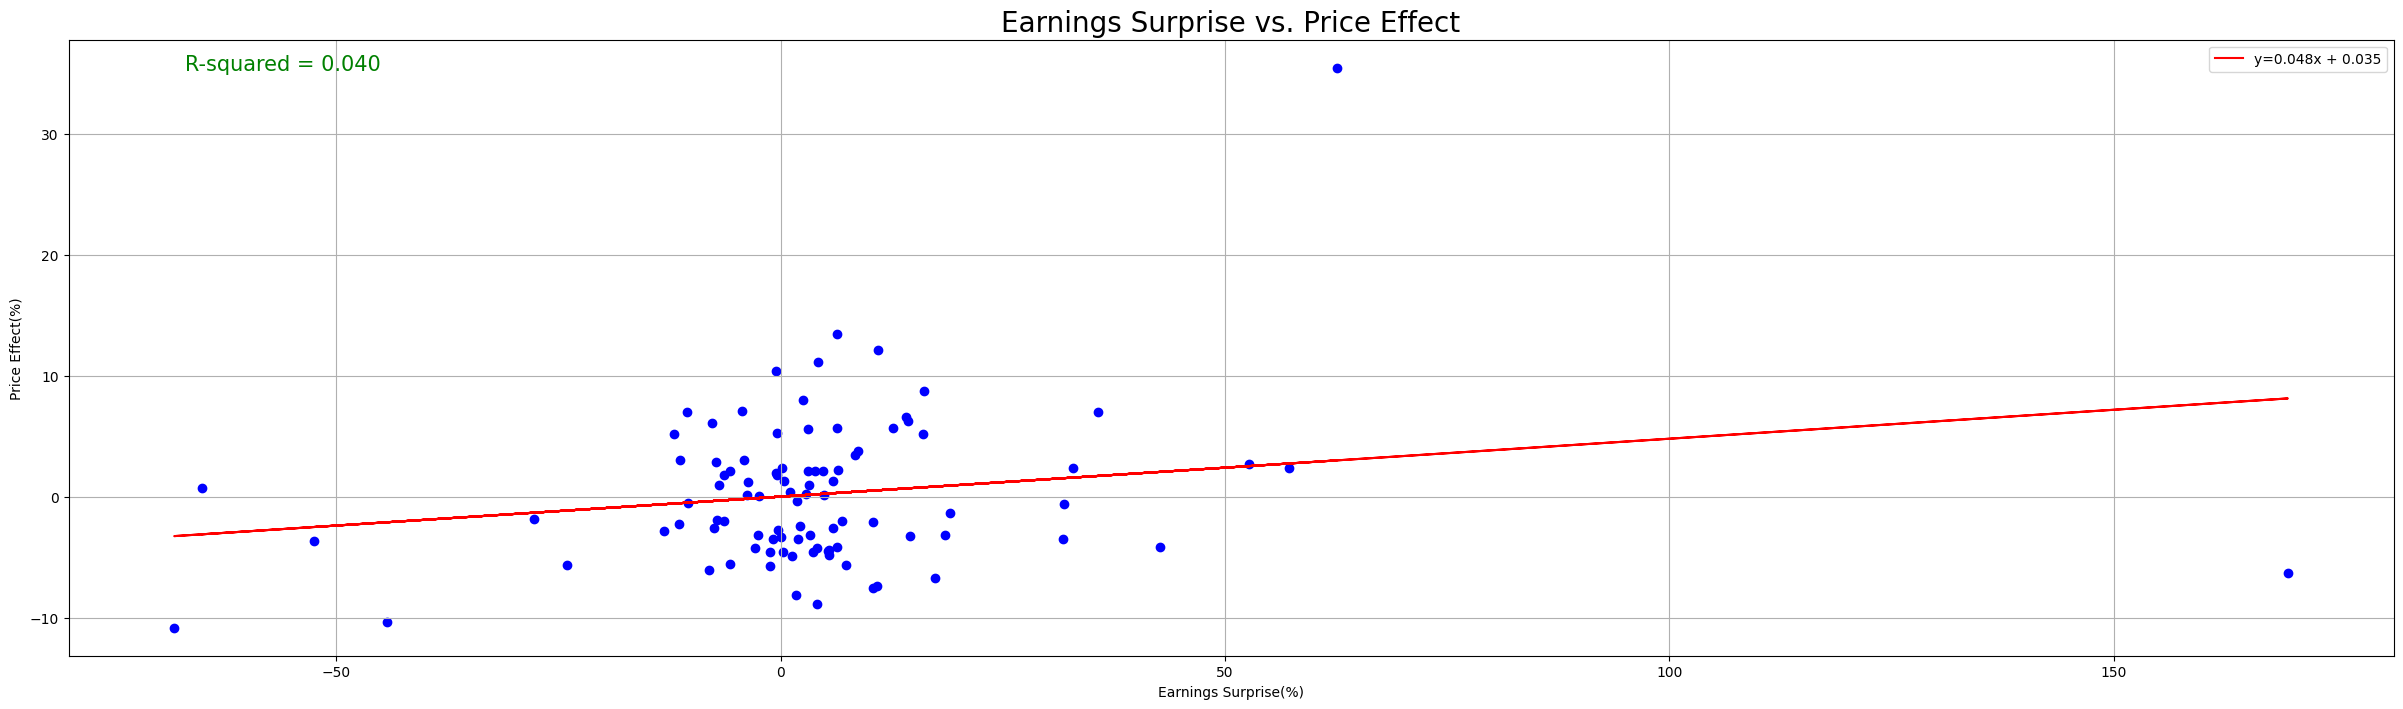

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Drop rows with NaN values in 'Surprise(%)' and 'Price Effect (%)' columns
filtered_earnings_data = earnings_data.dropna(subset=['Surprise(%)', 'Price Effect (%)'])

# Linear regression
slope, intercept = np.polyfit(filtered_earnings_data['Surprise(%)'], filtered_earnings_data['Price Effect (%)'], 1)
x = np.array(filtered_earnings_data['Surprise(%)'])
y_pred = slope * x + intercept

# Compute r-squared
correlation_matrix = np.corrcoef(filtered_earnings_data['Surprise(%)'], filtered_earnings_data['Price Effect (%)'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

# Scatter plot with regression line
plt.figure(figsize=(30, 8))
plt.scatter(filtered_earnings_data['Surprise(%)'], filtered_earnings_data['Price Effect (%)'], color='blue', marker='o')
plt.plot(x, y_pred, color='red', label=f'y={slope:.3f}x + {intercept:.3f}')  # regression line
plt.title('Earnings Surprise vs. Price Effect', fontsize = 20)
plt.xlabel('Earnings Surprise(%)')
plt.ylabel('Price Effect(%)')
plt.grid(True)
plt.legend(loc="upper right")
plt.annotate(f'R-squared = {r_squared:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=15, color='green')
plt.show()

## 3. Price, Volatility and Volume Around Earnings

###  3.1 Price Movement Around Earnings

- The period surrounding earnings announcements is typically marked by heightened investor attention, often translating into significant price movements.

- To analyze these fluctuations, we normalize the yfinanceretrieved stock prices to the closing price five days before the earnings date to observe relative changes.

- The Python script below sets up the necessary parameters and iterates through each earnings date to create a time series of normalized prices.

- These are subsequently plotted to visualize price movements around earnings dates, providing a clear depiction of market behavior during these critical periods.

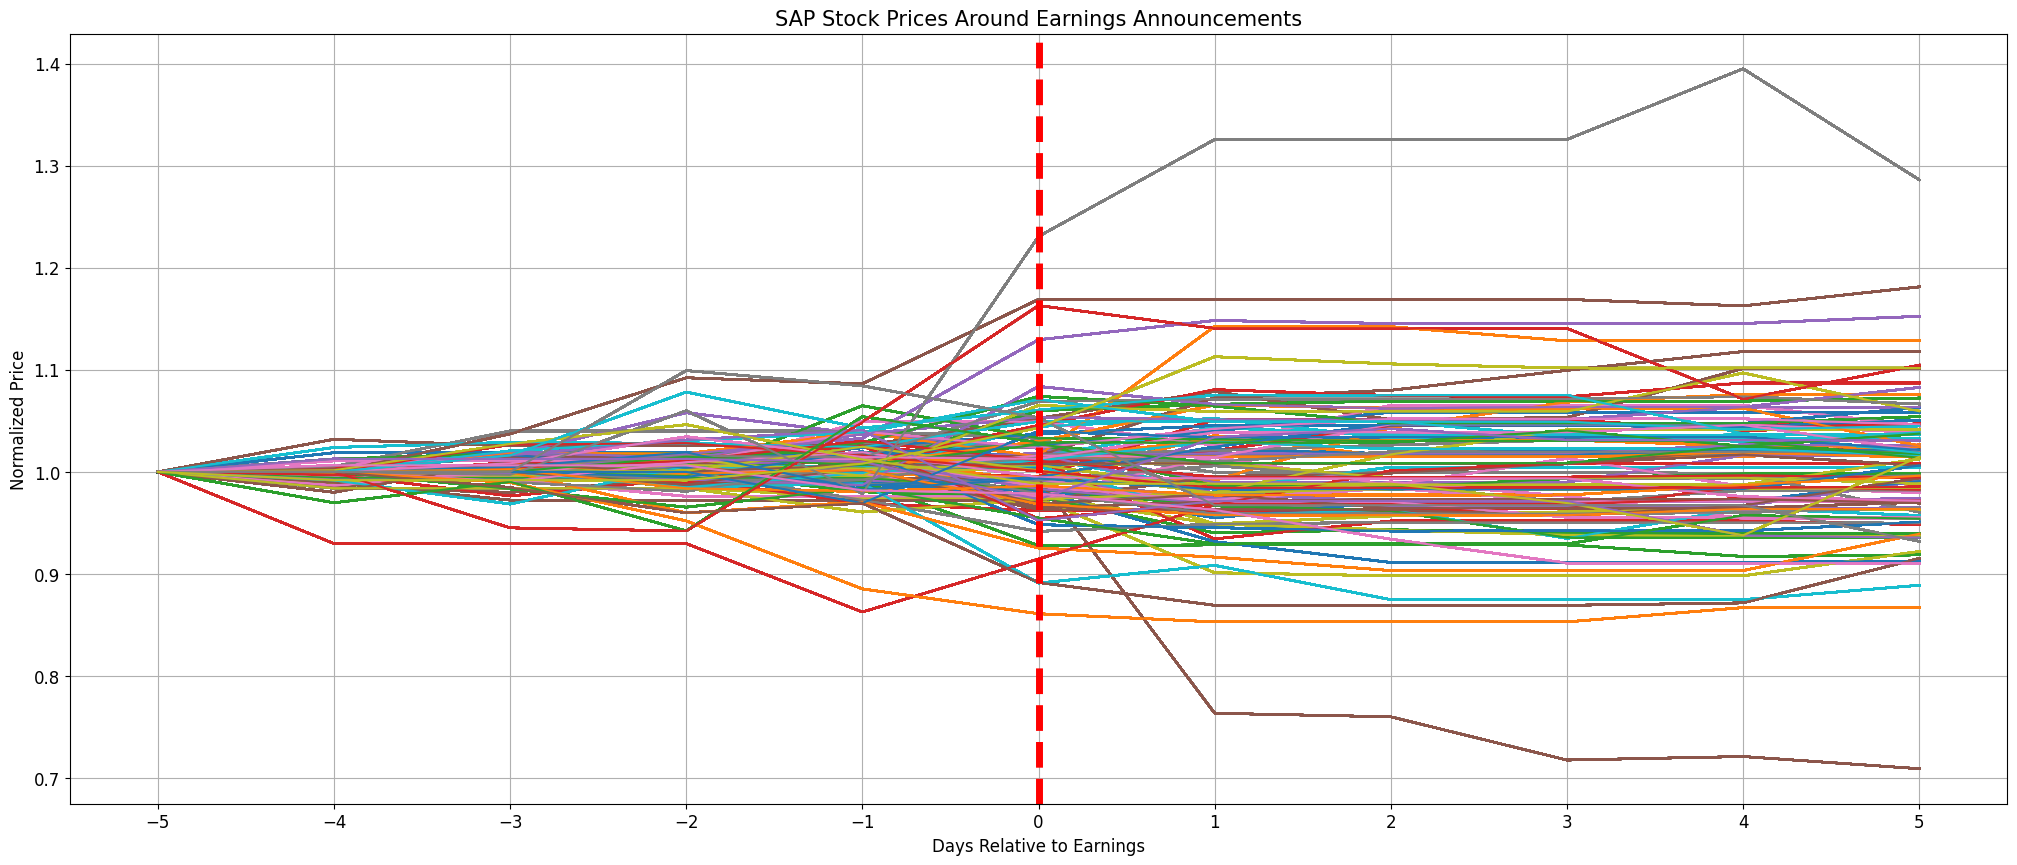

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# Define the ticker symbol
tickerSymbol = 'SAP'

# Check the minimum and maximum earnings dates from the 'df' DataFrame
min_earnings_date = earnings_data['Earnings Date'].min()
max_earnings_date = earnings_data['Earnings Date'].max()

# Get data on this ticker
stock_data = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker within the range of earnings dates
hist = stock_data.history(start=min_earnings_date, end=max_earnings_date)

# Make the datetime index timezone-naive for compatibility with earnings dates
hist.index = hist.index.tz_localize(None)

# Initialize an empty list to hold the price series
price_series_list = []

# Extract relevant price data
for index, row in earnings_data[['Earnings Date']].iterrows():
    earnings_date = pd.to_datetime(row['Earnings Date']).date()

    # Adjust the start date to ensure there's data available for forward-filling
    extended_start_date = earnings_date - timedelta(days=7)  # extending to ensure we have data to forward-fill
    start_date = earnings_date - timedelta(days=5)
    end_date = earnings_date + timedelta(days=5)

    # Select the stock prices for the extended date range
    prices = hist.loc[extended_start_date:end_date, 'Close']

    if prices.empty:
        print(f"No price data available for the range {extended_start_date} to {end_date}. Skipping.")
        continue

    # Forward-fill missing values, this time with available data due to extended range
    all_days = pd.date_range(start=extended_start_date, end=end_date, freq='D')
    prices = prices.reindex(all_days, method='ffill')

    # Truncate the prices Series to only the date range we're interested in (i.e., -5 to +5 days around earnings)
    prices = prices.loc[start_date:end_date]

    # Normalize prices based on the closing price 5 days before earnings
    prices /= prices.iloc[0]

    # Add the series to the list with the days relative to earnings as the new index
    price_series_list.append(prices.reset_index(drop=True))  # reset_index for proper alignment during concatenation

# Check if the price_series_list is empty
if not price_series_list:
    raise ValueError("No price data was added to the list. Please check your input data and date ranges.")

# Concatenate all the series into a single DataFrame
price_data = pd.concat(price_series_list, axis=1)

# Correcting the index to represent days relative to earnings
price_data.index = np.arange(-5, 6)

# Now, let's plot each series correctly
plt.figure(figsize=(25, 10))

# Iterate over each series and plot
for column in price_data.columns:
    plt.plot(price_data.index, price_data[column])  # Each series represents a different earnings date

plt.axvline(x=0, color='red', linestyle='--', label='Earnings Date', linewidth=5)
plt.xticks(np.arange(-5, 6, 1))  # Ensuring the x-axis reflects -5 to +5 days

# Adding title and labels
plt.title('SAP Stock Prices Around Earnings Announcements', fontsize=15)
plt.xlabel('Days Relative to Earnings', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)

# Set the tick size
plt.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size

#plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')  # Adjusted the legend position so it doesn't overlap the plot
plt.grid(True)
plt.show()

## 3.2 Volatility Action Around Earnings
### Volatility often increases around earnings announcements due to the uncertainty and potential for surprises. By computing the 20-day rolling volatility of the stock price, we aim to capture and visualize this phenomenon.

- The following Python script calculates the daily returns and rolling volatility, then isolates the volatility around each earnings date. The plotted data reflects the market's anticipation and reaction to new information, a vital consideration for risk assessment and trading strategies.

- This visualization offers investors a lens through which to view the risk profile of a stock around earnings announcements, critical for managing portfolios during earnings seasons.



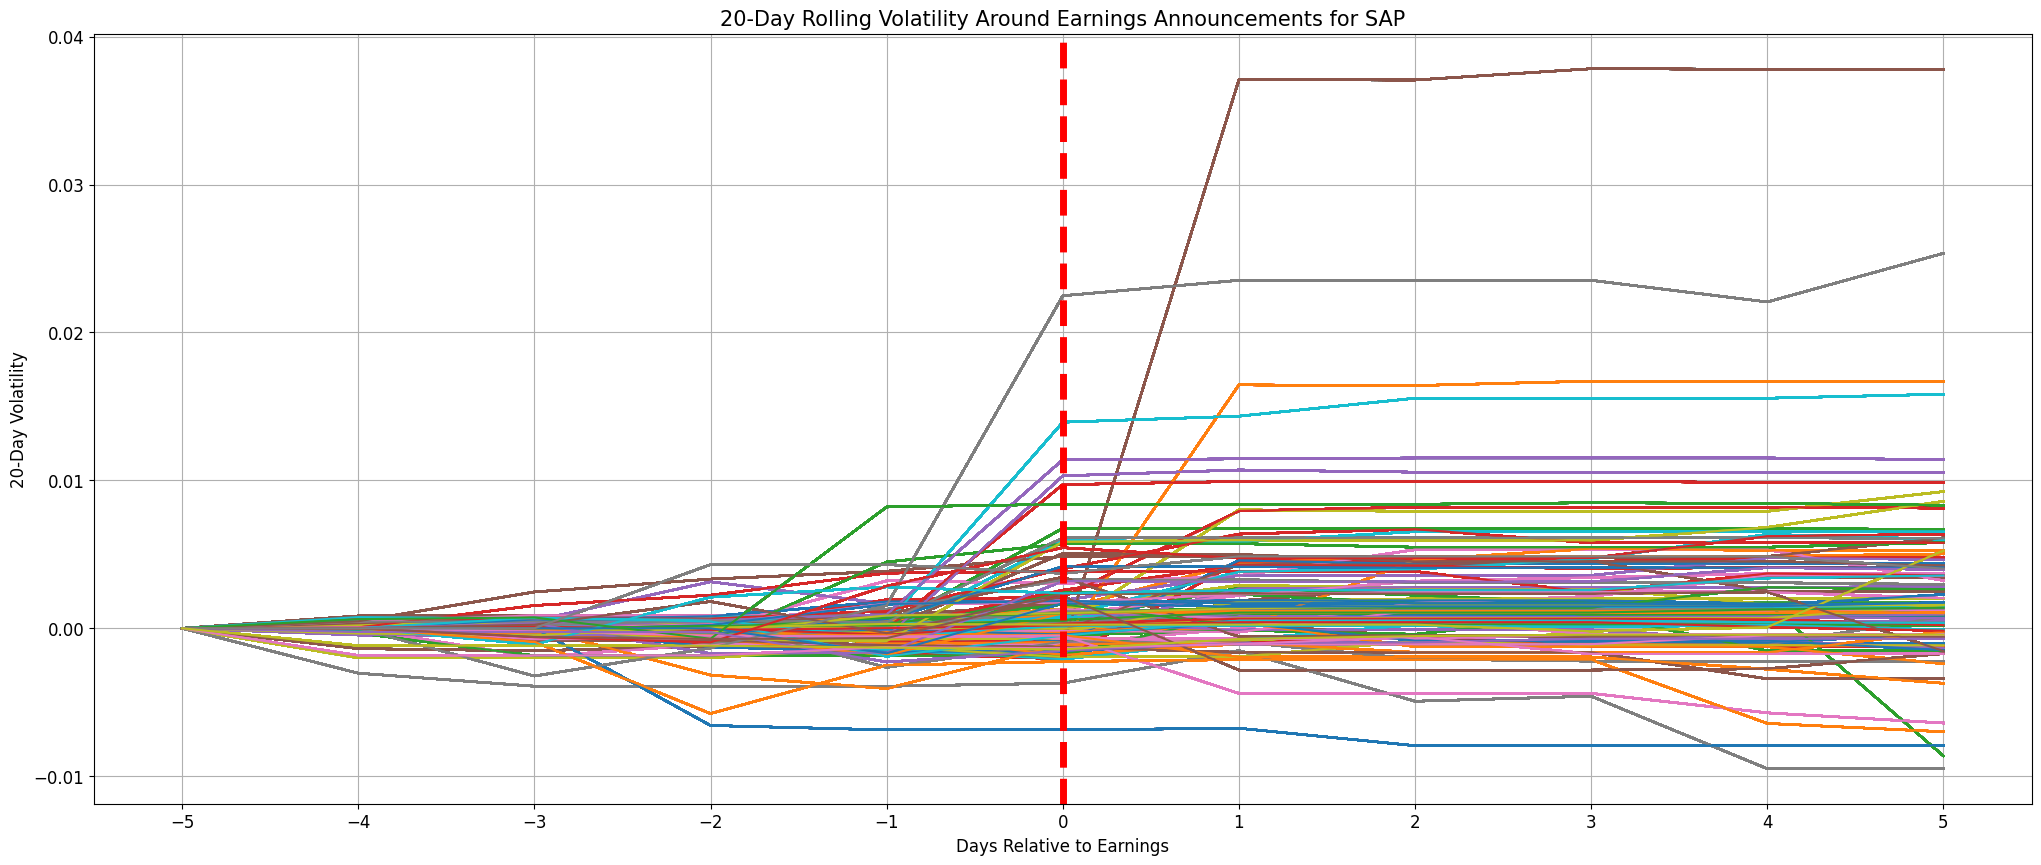

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# Define the ticker symbol and time range
tickerSymbol = 'SAP'
startDate = earnings_data['Earnings Date'].min()
endDate = earnings_data['Earnings Date'].max()

# Get data on this ticker
stock_data = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
hist = stock_data.history(start=startDate, end=endDate)
hist.index = hist.index.tz_localize(None)  # Make timezone-naive

# Calculate daily returns
hist['Returns'] = hist['Close'].pct_change()

# Calculate 20-day rolling volatility
hist['20D Volatility'] = hist['Returns'].rolling(window=20).std()


# Initialize an empty list to hold the volatility series
volatility_series_list = []

# Extract relevant volatility data
for index, row in earnings_data[['Earnings Date']].iterrows():
    earnings_date = pd.to_datetime(row['Earnings Date']).date()
    extended_start_date = earnings_date - timedelta(days=7)
    start_date = earnings_date - timedelta(days=5)
    end_date = earnings_date + timedelta(days=5)

    # Select the volatility for the extended date range
    volatilities = hist.loc[extended_start_date:end_date, '20D Volatility']

    if volatilities.empty:
        print(f"No volatility data available for the range {extended_start_date} to {end_date}. Skipping.")
        continue

    # Forward-fill missing values
    all_days = pd.date_range(start=extended_start_date, end=end_date, freq='D')
    volatilities = volatilities.reindex(all_days, method='ffill')

    # Truncate the volatilities Series to only the date range we're interested in (i.e., -5 to +5 days around earnings)
    volatilities = volatilities.loc[start_date:end_date]

    # Reindex the series to start at 0 on day -5
    volatilities = volatilities - volatilities.iloc[0]
    
    # Add the series to the list with the days relative to earnings as the new index
    volatility_series_list.append(volatilities.reset_index(drop=True))

if not volatility_series_list:
    raise ValueError("No volatility data was added to the list. Please check your input data and date ranges.")

# Concatenate all the series into a single DataFrame
volatility_data = pd.concat(volatility_series_list, axis=1)

# Correcting the index to represent days relative to earnings
volatility_data.index = np.arange(-5, 6)

# Now, let's plot each series correctly
plt.figure(figsize=(25, 10))
for column in volatility_data.columns:
    plt.plot(volatility_data.index, volatility_data[column])  # Each series represents a different earnings date

plt.axvline(x=0, color='red', linestyle='--', label='Earnings Date', linewidth=5)
plt.xticks(np.arange(-5, 6, 1))
plt.title(f'20-Day Rolling Volatility Around Earnings Announcements for {tickerSymbol}', fontsize=15)
plt.xlabel('Days Relative to Earnings', fontsize=12)
plt.ylabel('20-Day Volatility',fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()

## 3.3 Volume Changes Around Earnings
**Trading volume is another key indicator that can signal the market's reaction to earnings reports. A surge in volume often accompanies significant earnings surprises, reflecting increased trading activity as investors reassess the stock's value.**

- Utilizing yfinance, we extract and analyze the trading volume around earnings dates. The script below processes this data, aligning it with the earnings dates and reindexing the series to highlight changes in trading activity.

- By visualizing the reindexed volume data, investors can gauge the intensity of the market's response to earnings announcements, which can be a useful proxy for market sentiment and investor interest.

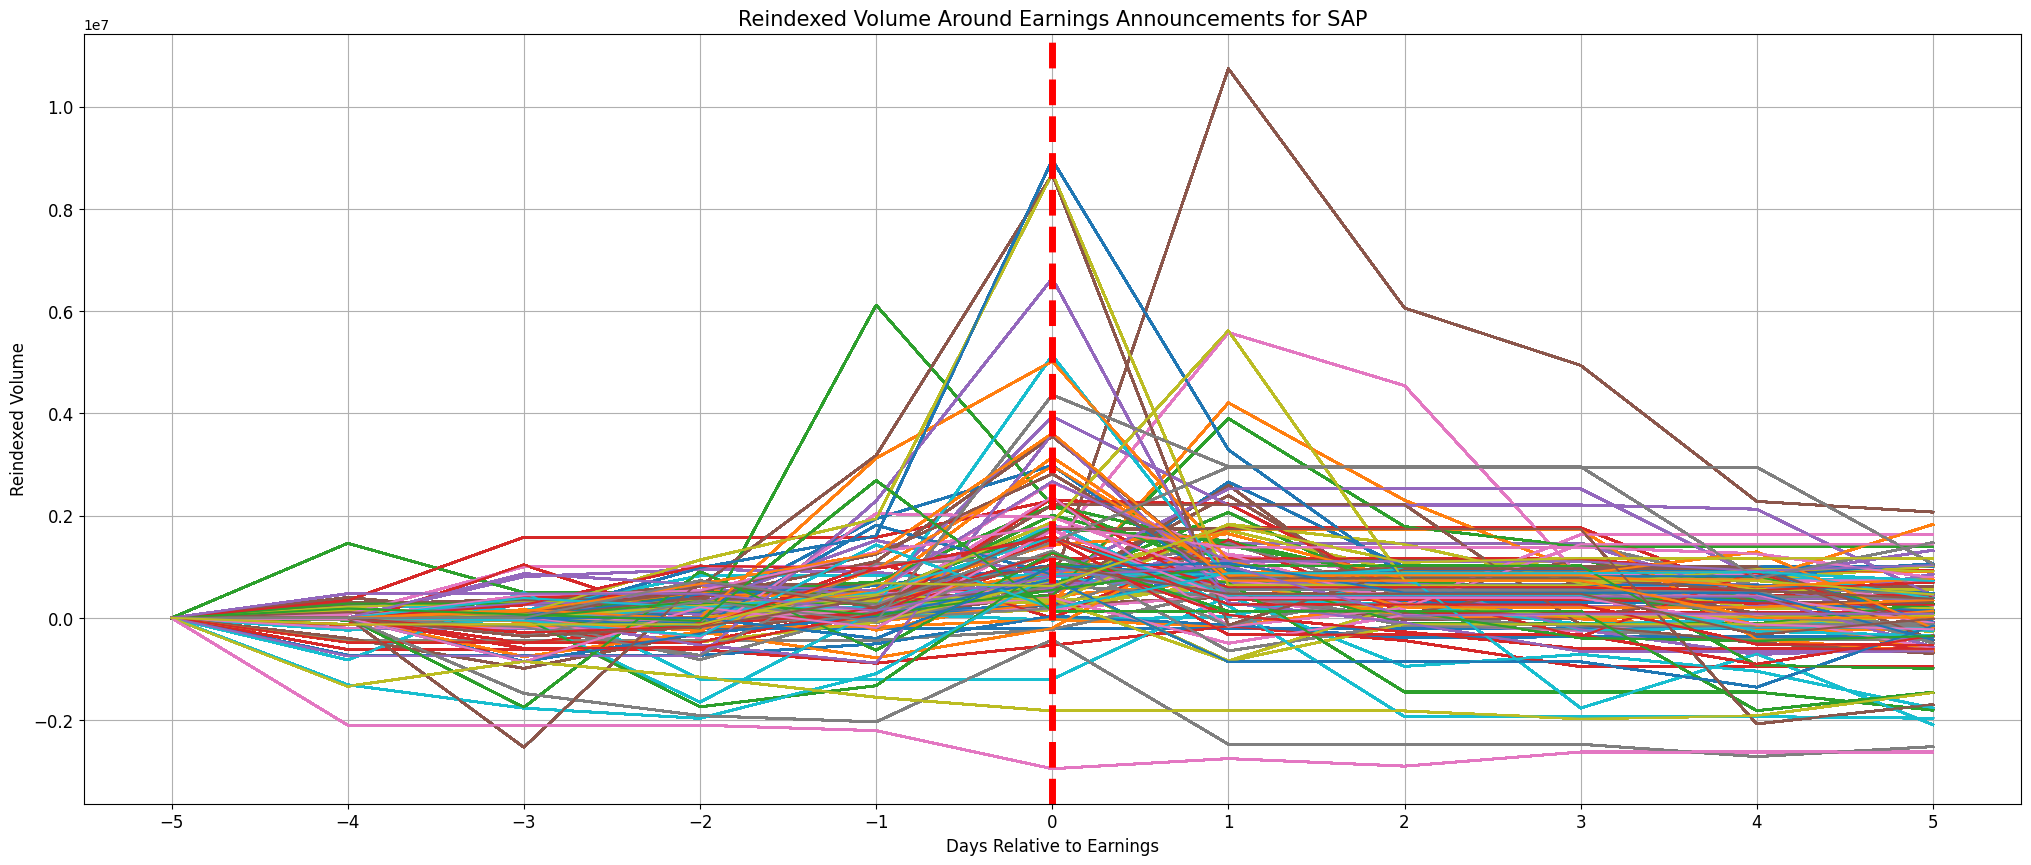

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# Define the ticker symbol and time range you want to analyze
tickerSymbol = 'SAP'
startDate = earnings_data['Earnings Date'].min()
endDate = earnings_data['Earnings Date'].max()

# Get data on this ticker
stock_data = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
hist = stock_data.history(start=startDate, end=endDate)
hist.index = hist.index.tz_localize(None)  # Make timezone-naive

# Initialize an empty list to hold the volume series
volume_series_list = []

# Extract relevant volume data
for index, row in earnings_data[['Earnings Date']].iterrows():
    earnings_date = pd.to_datetime(row['Earnings Date']).date()
    extended_start_date = earnings_date - timedelta(days=7)
    start_date = earnings_date - timedelta(days=5)
    end_date = earnings_date + timedelta(days=5)

    # Select the volume for the extended date range
    volumes = hist.loc[extended_start_date:end_date, 'Volume']

    if volumes.empty:
        print(f"No volume data available for the range {extended_start_date} to {end_date}. Skipping.")
        continue

    # Forward-fill missing values
    all_days = pd.date_range(start=extended_start_date, end=end_date, freq='D')
    volumes = volumes.reindex(all_days, method='ffill')

    # Truncate the volumes Series to only the date range we're interested in (i.e., -5 to +5 days around earnings)
    volumes = volumes.loc[start_date:end_date]

    # ### START OF REINDEXING ###
    # Reindex the series to start at 0 on day -5
    volumes = volumes - volumes.iloc[0]
    # ### END OF REINDEXING ###

    # Add the series to the list with the days relative to earnings as the new index
    volume_series_list.append(volumes.reset_index(drop=True))

if not volume_series_list:
    raise ValueError("No volume data was added to the list. Please check your input data and date ranges.")

# Concatenate all the series into a single DataFrame
volume_data = pd.concat(volume_series_list, axis=1)

# Correcting the index to represent days relative to earnings
volume_data.index = np.arange(-5, 6)


# Now, let's plot each series correctly
plt.figure(figsize=(25, 10))
for column in volume_data.columns:
    plt.plot(volume_data.index, volume_data[column])  # Each series represents a different earnings date

plt.axvline(x=0, color='red', linestyle='--', label='Earnings Date', linewidth=5)
plt.xticks(np.arange(-5, 6, 1))
plt.title(f'Reindexed Volume Around Earnings Announcements for {tickerSymbol}',fontsize=15)
plt.xlabel('Days Relative to Earnings',fontsize=12)
plt.ylabel('Reindexed Volume',fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()

## 4. Historical and Future Movement Probabilities
### We now consider three different type of analysis to estimate potential future price movements and associated probabilities. Namely, we use the historical earnings price movements, market implied movements from opcion prices and Monte Carlo simulated prices using the historical earnings data.

### 4.1 Historical Movement Probabilities
- Understanding historical movement probabilities can be invaluable. It allows for an estimation of how the stock price might behave around earnings announcements, based on historical volatility and price movements in previous earnings annoucements.

- The approach is as follows: we normalize the price data to the period leading up to the earnings announcement, and then analyze the distribution of these paths to determine the probability of various outcomes, e.g. a 10% increase/decrease within n-days.

[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_17106/2971276285.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  subset = subset / subset[0]


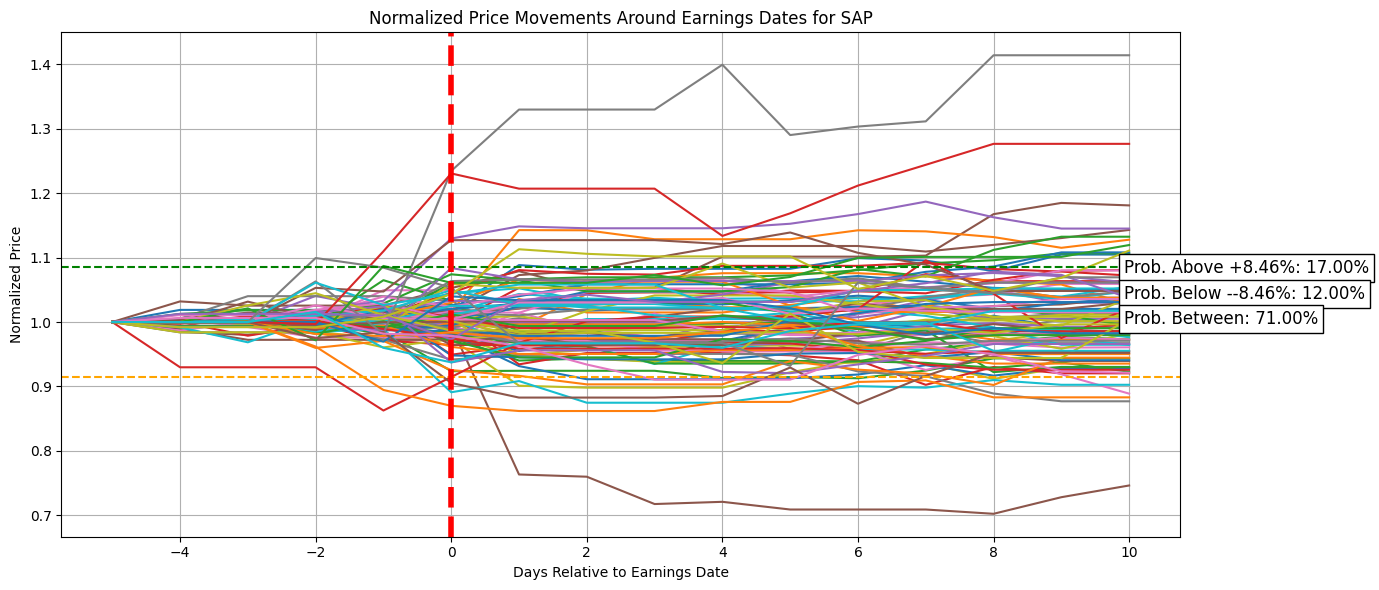

In [19]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

earnings_df = earnings_data.copy()

# Define the windows
pre_announcement_window = 5
post_announcement_window = 10

# Adjust starting date for yfinance data retrieval
start_date = earnings_df['Earnings Date'].min() - pd.Timedelta(days=pre_announcement_window)
end_date = earnings_df['Earnings Date'].max() + pd.Timedelta(days=post_announcement_window)
ticker = 'SAP'
stock_data = yf.download(ticker, start=start_date, end=end_date)

def ensure_window_size(subset, earning_date, pre_announcement_window, post_announcement_window):
    expected_dates = [earning_date + pd.Timedelta(days=i) for i in range(-pre_announcement_window, post_announcement_window + 1)]
    for expected_date in expected_dates:
        if expected_date not in subset.index:
            subset.loc[expected_date] = np.nan
    return subset.sort_index()

all_normalized_prices = []
for earning_date in earnings_df['Earnings Date']:
    start = earning_date - pd.Timedelta(days=pre_announcement_window)
    end = earning_date + pd.Timedelta(days=post_announcement_window)
    subset = stock_data.loc[start:end]['Close'].copy()

    # Ensure subset has the expected length
    subset = ensure_window_size(subset, earning_date, pre_announcement_window, post_announcement_window)

      # normalize
    subset.ffill(inplace=True)  # forward fill
    subset.bfill(inplace=True)  # backward fill
    subset = subset / subset[0]
    all_normalized_prices.append(subset.tolist())


# Define the price movement thresholds
#upper_threshold = 1.02  # 2% increase
#lower_threshold = 0.98  # 2% decrease

# Retrieve the latest closing price
latest_close_price = stock_data['Close'].iloc[-1]

# Define your absolute upper and lower price thresholds in mind
upper_price_threshold = latest_close_price + 15  # Assuming you have +5 in mind for the upper threshold
lower_price_threshold = latest_close_price - 15  # Assuming you have -5 in mind for the lower threshold

# Calculate the percentage thresholds
upper_threshold = upper_price_threshold / latest_close_price
lower_threshold = lower_price_threshold / latest_close_price

# Count the occurrences of each price movement category
above_count = 0
below_count = 0
between_count = 0

for prices in all_normalized_prices:
    if max(prices) > upper_threshold:
        above_count += 1
    elif min(prices) < lower_threshold:
        below_count += 1
    else:
        between_count += 1

# Calculate probabilities
total_periods = len(all_normalized_prices)
prob_above = above_count / total_periods
prob_below = below_count / total_periods
prob_between = between_count / total_periods

# Plotting
window_days = list(range(-pre_announcement_window, post_announcement_window + 1))
plt.figure(figsize=(12, 6))
for prices, date in zip(all_normalized_prices, earnings_df['Earnings Date']):
    plt.plot(window_days, prices, label=date.date())

# Add horizontal lines for the percentage thresholds
plt.axhline(y=upper_threshold, color='green', linestyle='--', label=f"+{upper_threshold-1:.2%}% Threshold")
plt.axhline(y=lower_threshold, color='orange', linestyle='--', label=f"-{lower_threshold-1:.2%}% Threshold")

plt.title(f"Normalized Price Movements Around Earnings Dates for {ticker}")
plt.xlabel("Days Relative to Earnings Date")
plt.ylabel("Normalized Price")
plt.axvline(0, color='red', linestyle='--', lw=4)  # vertical line at earnings day
#plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the plot with the probabilities
plt.annotate(f"Prob. Above +{upper_threshold-1:.2%}: {prob_above:.2%}", xy=(0.95, 0.55), xycoords='axes fraction', fontsize=12, verticalalignment='top', bbox=dict(boxstyle="square", fc="white"))
plt.annotate(f"Prob. Below -{lower_threshold-1:.2%}: {prob_below:.2%}", xy=(0.95, 0.50), xycoords='axes fraction', fontsize=12, verticalalignment='top', bbox=dict(boxstyle="square", fc="white"))
plt.annotate(f"Prob. Between: {prob_between:.2%}", xy=(0.95, 0.45), xycoords='axes fraction', fontsize=12, verticalalignment='top', bbox=dict(boxstyle="square", fc="white"))

plt.show()